# Maneuver Recognition Package

ManeuverRecognition is a python package providing functions for the preprocessing of time series data for classification, the creation of predictive LSTM based  models and the evaluation of multi class predictions. Its functionalities are demonstrated in section 2 using a real world use case in the domain of vehicle telematics. The package documentation can be found in section 3.


# Content

**[1. About](#heading--1)**

**[2. Implementation: Real world vehicle maneuver recognition using smartphone sensors and LSTM models](#heading--2)**

  * [2.1. Project background](#heading--2-1)
  * [2.2. Dataset](#heading--2-2)
  * [2.3. Preprocessing](#heading--2-3)
      * [2.3.1. Windowing and Train- / Test-Splitting](#heading--2-3-1)
      * [2.3.2. Dropping maneuvers and balancing classes](#heading--2-3-2)
      * [2.3.3. Label encoding and variable transformation](#heading--2-3-3)
  * [2.4. Modelling](#heading--2-4)
    * [2.4.1. Defining model architecture and initializing the model](#heading--2-4-1)
    * [2.4.2. Training the model](#heading--2-4-2) 
  
  * [2.5. Evaluation](#heading--2-5)
    * [2.5.1. Validation accuracy and validation loss](#heading--2-5-1)
    * [2.5.2. Correlation matrix](#heading--2-5-2)
    * [2.5.3. Recall heatmap](#heading--2-5-3) 
    * [2.5.4. Precision heatmap](#heading--2-5-4)
  
  * [2.6. Conclusion](#heading--2-6)

**[3. Documentation](#heading--3)**
   * [3.1. Preprocessing module](#heading--3-1)
      * [3.1.1. create_dataset()](#heading--3-1-1)
      * [3.1.2. timeseries_train_test_split()](#heading--3-1-2)
      * [3.1.3. remove_maneuvers()](#heading--3-1-3)
      * [3.1.4. LabelEncoding](#heading--3-1-4)
      * [3.1.5. transform_to_variables()](#heading--3-1-5)
   * [3.2. Modelling module](#heading--3-2)
      * [3.2.1. ManeuverModel](#heading--3-2-1)
      * [3.2.2. train()](#heading--3-2-2)
      * [3.2.3. test()](#heading--3-2-3)
      * [3.2.4. fit_model()](#heading--3-2-4)
   * [3.3. Evaluation module](#heading--3-3)
      * [3.3.1. relative_values()](#heading--3-3-1)
      * [3.3.2. plot_training_process()](#heading--3-3-2)
      * [3.3.3. create_heatmap()](#heading--3-3-3)
      * [3.3.4. confusion_heatmap()](#heading--3-3-4)
      * [3.3.5. precision_heatmap()](#heading--3-3-5)
      * [3.3.6. recall_heatmap()](#heading--3-3-6)

# 1. About <a name="heading--1"/>

Although there has been a great deal of research on developing maneuver recognition systems and models, there are few publicly available resources that allow easy and quick transformation of data and creation of models for this application. In contrast to the classification of data that is available as individual, separate cases, maneuver recognition has very specific requirements for the preprocessing, model development and model evaluation. These arise from the necessity of these models to be applicable to a continuous data stream, the seamless transition of classes and the numerous influence factors when performing maneuvers in real road traffic.

The ManeuverRecognition package was therefore developed to simplify the aforementioned processes and make the task of maneuver recognition more accessible. In the following, its functionality is demonstrated using real driving data.

A more detailed research paper on the background of this package is also available here: ManeuverRecognition - a python package for timeseries classification in the domain of vehicle telematics


*Abstract - In the domain of vehicle telematics the automated recognition of driving maneuvers is used to classify and evaluate driving behaviour. This not only serves to enhance the personalization of insurance policies, but also to increase road safety, reduce accidents and the associated costs as well as to reduce fuel consumption and support environmentally friendly driving. In this context maneuver recognition technically requires a continuous application of time series classification which poses special challenges to the preprocessing of telematic sensor data, the training of predictive models, and the prediction itself. Although much research has been done in the field of gathering relevant data or the methods to build predictive models for the task of maneuver recognition, there is a need for python packages and functions that allow to quickly transform data into the required structure as well as to build and evaluate such models. The ManeuverRecognition package was therefore developed to provide the necessary functions for preprocessing, modelling and evaluation and also includes a ready to use LSTM based network structure that can be modified. The implementation of the package is demonstrated using real driving data of three different persons recorded via smartphone sensors.*

# 2. Implementation: Real world vehicle maneuver recognition using smartphone sensors and LSTM models <a name="heading--2"/>

## Project background <a name="heading--2-1"/>

In this section, the implementation of the package is demonstrated using real world driving data of a previous research project which has been carried out at the Harz University of Applied Sciences. The objective of the research project was to collect comprehensive driving data of different persons in real world traffic. Since the recording of telematics data via special hardware is difficult to replicate, an application to record smartphone sensors was developed for this purpose. Then trips of three persons using different vehicles were recorded using the smartphone application and a dashcam for the subsequent manual assignment of maneuver types to the captured sensor data. 

A more detailed description of the research project can be found this corresponding paper (currently only in german - english version coming soon).

## 2.2 Dataset <a name="heading--2-2"/>
The dataset contains sensor data of a smartphones accelerometer, gyroscope and GPS which were recorded during a total of three trips driven by different persons using different vehicles on the same 60.7 kilometer route. The accelerometer was used to record the acceleration forces along three orthogonal axes in meters per square second without taking the gravitational force into account. The gyroscope was used to measure rotational speed around the same three axes in radians per second. GPS data includes latitude, longitude, altitude, accuracy as an estimated horizontal accuracy radius in meters, and speed in meters per second. The following picture shows the positioning of the smartphone during the recordings and the resulting alignment of the sensors axes.

![Sensor axes with positioning in vehicle](images/sensor_positioning.png)


The final dataset is composed of 19 variables which include smartphone data as well as manually assigned variables like the maneuver type, the route section, the road type, a unique maneuver identifier, the vehicle and an identifier for the driving person. In addition to the maneuver type there is also the variable maneuver element which represents a more refined category system. The variables of smartphone data include datetime, the accelerometer and gyroscope sensor variables per axes, as well as GPS information such as longitude, latitude, altitude, accuracy and speed.

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import torch
import torch.nn as nn

In [2]:
df = pd.read_csv("data/SensorRec_data_eng.csv")
df.head(5)

datetime      accX      accY      accZ     gyroX     gyroY  \
0  2023-01-06 10:44:29.466  0.021387 -0.006456 -0.084595 -0.072036 -0.009720   
1  2023-01-06 10:44:29.958  0.023271  0.100068  0.143770  0.013182  0.004794   
2  2023-01-06 10:44:30.456  0.030368 -0.006946  0.019102  0.000000 -0.001997   
3  2023-01-06 10:44:30.957  0.012233 -0.005673  0.002899  0.000266  0.001198   
4  2023-01-06 10:44:31.456  0.017861  0.001417  0.017249 -0.001332 -0.002397   

      gyroZ   latitude  longitude   altitude  accuracy     speed  maneuverID  \
0 -0.006924  52.366269   9.761421  98.700005    11.716  0.060892  000000-P1M   
1  0.000399  52.366269   9.761421  98.700005    11.716  0.060892  000000-P1M   
2  0.001198  52.366270   9.761421  98.700005     9.591  0.035770  000000-P1M   
3  0.001065  52.366270   9.761421  98.700005     9.591  0.035770  000000-P1M   
4  0.000399  52.366270   9.761421  98.700005     9.591  0.035770  000000-P1M   

  maneuverType maneuverElement  section   roadType      vehicle person  
0   stationary      stationary        1  city_road  Skoda Fabia    P01  
1   stationary      stationary        1  city_road  Skoda Fabia    P01  
2   stationary      stationary        1  city_road  Skoda Fabia    P01  
3   stationary      stationary        1  city_road  Skoda Fabia    P01  
4   stationary      stationary        1  city_road  Skoda Fabia    P01

For this demonstration the accelerometer and gyroscope variables as well as the GPS speed and the road type will be used to predict the maneuver type. Although the road type was also manually labeled it can be used since the road type of new driving data could be accessed by matching the GPS coordinates with publicly available road data. In order to use the categorical variable road type it will first be converted into dummy variables. To prevent mixing the data of the three different persons when executing a rolling windowing function in the preprocessing the data of the three persons will be split and recombined afterwards.

In [3]:
df = pd.get_dummies(data=df, columns=['roadType'])
df_p1 = df.loc[df['person'] == 'P01', :]
df_p2 = df.loc[df['person'] == 'P02', :]
df_p3 = df.loc[df['person'] == 'P03', :]

dataframe_list = [df_p1, df_p2, df_p3]

## 2.3 Preprocessing <a name="heading--2-3"/>

As already mentioned, the automated recognition of maneuvers has special requirements to the preprocessing of the given data. In addition to common preprocessing for the application of machine learning, such as reshaping, train & test splitting or class balancing, it is particularly necessary to prepare the data so that it can be processed by recurrent networks. Since the intention of maneuver recognition in the domain of vehicle telematics is to continuously apply the classification model to a stream of new driving data, it must therefore be trained in a way to work with a continuous stream of unknown data.

### 2.3.1 Windowing and Train-/Test-Splitting <a name="heading--2-3-1"/>

The objective is to create a classification model which can correctly identify driving maneuvers in unknown data of future driving records. Therefore, to train such a model, we cannot simply use the maneuvers that have already been assigned to their IDs separately as training and testing cases. As new recorded data comes in the form of a continuous time series for which it is not known at which point in time a maneuver begins or ends, the available training and testing data must also be sampled via a rolling window. At the same time it is important that there is absolutely no data leakage between the training and testing data.

In order to do that, we are in need of two specific functions:
1. A function to split the data into training and testing data before the windowing is applied. If we do not split training and testing data before using the windowing function, there will be data leakage because overlapping windows may end up in both partitions.
2. A windowing function that gets our data and returns windows with a specific amount of time steps and a specific step size between those windows in the shape of (cases, timesteps, variables) which is required for the LSTM model we will build later on.

For this purpose we can use the *timeseries_train_test_split* function in the *preprocessing* module. It first splits the given dataframe in an arbitrary number of partitions. Then it randomly selects some of these partitions for testing data in regard to our test size and removes them from a copy of the full dataframe. The remaining data will be used for training. We can also use this function to apply a robust scaling which will use the training data for fitting the scaler. The windowing function will then be applied on the training and testing partitions separately.

With this approach, it can still happen occasionally that we create unnatural transitions between maneuvers that occurred before and after the partitions we cut out for the test data or that we break some maneuvers by doing that. However, the amount of it, which depends on the number of splits we use, will be negligible, as it is clearly more important that we have no data leakage. 

The following parameters can be configured:
- splits: Number of random partitions in which data will be separated before windowing will be applied.
- test_size: Proportion of data to use for testing.
- time_steps: Length of windows in number of rows.
- step_size: Steps between windows in number of rows.
- scale: Bool whether we apply robust scaling or not.

Since we have data of three different persons and to ensure that different route segments of the trips can appear in the training and testing data we will apply the timeseries_train_test_split function on each individual dataset and combine the windowed data subsequently. Our windows will have a length of 14 timesteps which is 7 seconds in our dataset and we will use a stepsize of 6 timesteps which equals 3 seconds. We then merge the data with every window seperated and already in the right shape.

In [4]:
from maneuver_recognition import preprocessing

x_vars = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'speed', 'roadType_autobahn',
          'roadType_city_road','roadType_country_road','roadType_federal_highway']
y_var = 'maneuverType'
splits = 20
test_size = 0.2
time_steps = 14
step_size = 6

X_train, y_train, X_test, y_test = [], [], [], []
for df in dataframe_list:
    X_train_windows, y_train_classes, X_test_windows, y_test_classes = preprocessing.timeseries_train_test_split(df,
                x_variables=x_vars, y_variable=y_var, splits=splits, test_size=test_size,time_steps=time_steps,
                step_size=step_size, scale=True)

    
    X_train.append(X_train_windows)
    y_train.append(y_train_classes)
    X_test.append(X_test_windows)
    y_test.append(y_test_classes)
    
X_train, y_train, X_test, y_test = np.vstack(X_train), np.vstack(y_train), np.vstack(X_test), np.vstack(y_test)

Using this function will result in having our train and test data partitions in a shape of (cases, timesteps, variables) for x and (cases, label) for y. This shape is often required when using recurrent networks such as LSTM models which we will later do by using the *modelling* module.

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3833, 14, 11), (936, 14, 11), (3833, 1), (936, 1))

### 2.3.2 Dropping maneuvers and balancing classes <a name="heading--2-3-2"/>

To examine how many samples per driving maneuvers class are now present in the training and testing data, the following plot can be considered. It turns out that some maneuvers, such as overtaking or crossing an intersection, occurred in too few cases overall. Therefore these maneuvers will be excluded. By using the *remove_maneuvers* function we can drop maneuvers completely or apply undersampling to balance the class distributions within both our training and testing data.

In [9]:
fig = go.Figure(data=[
    go.Bar(name='Training data', x=np.unique(y_train), y=np.unique(y_train, return_counts=True)[1]),
    go.Bar(name='Test data', x=np.unique(y_test), y=np.unique(y_test, return_counts=True)[1])
])

fig.update_layout(barmode='stack', title="Amount of windows per maneuver type in the train and test data")
fig.update_xaxes(title_text='maneuver')
fig.update_yaxes(title_text='Amount')
fig.show()

In [505]:
drop_maneuvers = ['acceleration_lane', 'overtaking', 'deceleration_lane', 'crossing_roundabout', 'crossing_intersection']


X_train, y_train, X_test, y_test = preprocessing.remove_maneuvers(X_train, y_train, X_test, y_test, drop_maneuvers)
X_train, y_train, X_test, y_test = preprocessing.remove_maneuvers(X_train, y_train, X_test, y_test, 
                                                                  'continuous_driving', 0.9)
X_train, y_train, X_test, y_test = preprocessing.remove_maneuvers(X_train, y_train, X_test, y_test, 
                                                                      'stationary', 0.8)

There will still be a gentle imbalance between the maneuver classes, but now the data set is much better suited for training and testing our model and since we are dealing with real world data it is fine not to synthetically bring the data to an absolute balanced ratio. As with the split into training and testing data before, here it is also important to remove these maneuvers now in the form of windows and not directly from the raw time series data in the beginning. Removing maneuvers in the raw data would have led to breaking the time series and creating unnatural transitions between other maneuvers that were not intended to be affected.


In [506]:
fig = go.Figure(data=[
    go.Bar(name='Training data', x=np.unique(y_train), y=np.unique(y_train, return_counts=True)[1],
           text=np.unique(y_train, return_counts=True)[1], textposition='auto'),
    go.Bar(name='Test data', x=np.unique(y_test), y=np.unique(y_test, return_counts=True)[1],
           text=np.unique(y_test, return_counts=True)[1], textposition='auto')
])

fig.update_layout(barmode='stack', title="Amount of windows per maneuver type in the train and test data")
fig.update_xaxes(title_text='maneuver')
fig.update_yaxes(title_text='Amount')
fig.show()

### 2.3.3 Label encoding and variable transformation <a name="heading--2-3-3"/>

Next a label encoder is going to be created with the *LabelEncoding* class.  With the encoding object the target variable data can be encoded by using its *transform* function. The ojbect also stores the class labels so that the numeric values of the target variable can be transformed back to the labels using the *inverse_transform* function later.

In [507]:
encoding = preprocessing.LabelEncoding(y_train, y_test)
y_train, y_test = encoding.transform()

 The last step of preprocessing is to convert the training and testing data into the format of a PyTorch variable via the *transform_to_variables* function.

In [508]:
X_train, y_train, X_test, y_test = preprocessing.transform_to_variables(X_train, y_train, X_test, y_test)

## 2.4 Modelling <a name="heading--2-4"/>
Before using the *modelling* module of the maneuver recognition package, the device to use for training and testing our model can be set.

In [509]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### 2.4.1 Defining model architecture and initializing the model <a name="heading--2-4-1"/>
The *modelling* module can then be used to create and use a pytorch LSTM model. The base structure of the model is already defined and consists of a LSTM layer, two linear fully connected layers with a dropout of 0.3 and a final linear layer for multi class classification. Different configurations have been tested for this use case, but with the following parameters the architecture of the model can be configured individually:

- n_features: The number of expected features in the input x.
- n_classes: Number of classes for classification layer.
- n_hidden: Number of features in the hidden state of the LSTM layer.
- n_layers: Number of stacked LSTM layers.
- lstm_dropout: Value of applied dropout in LSTM layers.
- n_features_linear1: Number of features in first linear layer.
- n_features_linear2: Number of features in second linear layer.
- linear_dropout: Value of applied dropout between first and second linear layer.


In [510]:
from maneuver_recognition import modelling

number_of_features = X_train.shape[2]
number_of_classes = len(np.unique(y_train))
hidden_size = 24
lstm_layers = 2
lstm_dropout = 0.7

model     = modelling.ManeuverModel(number_of_features, number_of_classes, hidden_size, lstm_layers, lstm_dropout).to(device)

print(model)

ManeuverModel(
  (lstm): LSTM(11, 24, num_layers=2, batch_first=True, dropout=0.7)
  (full_layer1): Linear(in_features=24, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (full_layer2): Linear(in_features=64, out_features=32, bias=True)
  (classifier): Linear(in_features=32, out_features=8, bias=True)
)


### 2.4.2 Training the model <a name="heading--2-4-2"/>

Now we can use the function *fit_model* to fit the model. The function uses PyTorch's DataLoader wrapper, so we can directly input our training and testing data and define a specific batch size. We also have to set the number of epochs and define an optimizer as well as the type of loss function to use for the training process. The fit function is not part of the model class in order to enable independent use of the function with other models and model structures.

In [511]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()

loss_list, accuracy_list = modelling.fit_model(model, X_train, y_train, X_test, y_test, epochs=80,
                                         batch_size=128, loss_function=loss_fn, optimizer=optimizer,
                                         device=device)

Epoch 1 / 80
-------------------------------
Test Error: Accuracy: 18.9%, Avg loss: 2.066377 

Epoch 2 / 80
-------------------------------
Test Error: Accuracy: 18.9%, Avg loss: 2.046679 

Epoch 3 / 80
-------------------------------
Test Error: Accuracy: 36.1%, Avg loss: 2.015119 

Epoch 4 / 80
-------------------------------
Test Error: Accuracy: 30.4%, Avg loss: 1.950466 

Epoch 5 / 80
-------------------------------
Test Error: Accuracy: 32.9%, Avg loss: 1.820074 

Epoch 6 / 80
-------------------------------
Test Error: Accuracy: 45.0%, Avg loss: 1.637263 

Epoch 7 / 80
-------------------------------
Test Error: Accuracy: 46.1%, Avg loss: 1.483204 

Epoch 8 / 80
-------------------------------
Test Error: Accuracy: 48.9%, Avg loss: 1.375482 

Epoch 9 / 80
-------------------------------
Test Error: Accuracy: 49.6%, Avg loss: 1.269373 

Epoch 10 / 80
-------------------------------
Test Error: Accuracy: 52.5%, Avg loss: 1.189174 

Epoch 11 / 80
-------------------------------
Tes

## 2.5 Evaluation <a name="heading--2-5"/>

The *evaluation* module includes functions to evaluate both the training process and the quality of the model when predicting new data. 

### 2.5.1 Validation accuracy and validation loss <a name="heading--2-5-1"/>

By using the *plot_training_process* function of the evaluation module, the validation loss and validation accuracy per epoch which were returned using the *fit_model* function can be visualized. This helps to assess whether the training has led to over or underfitting. 

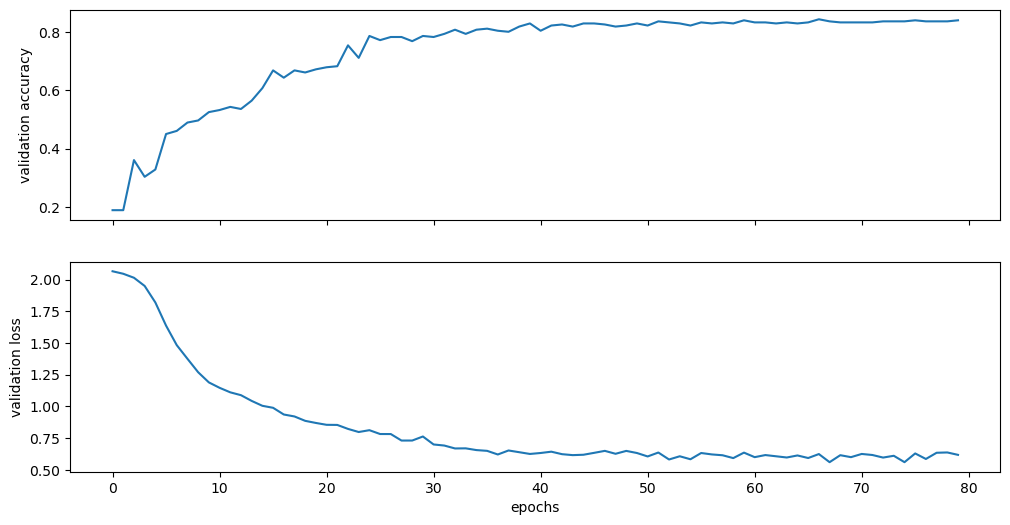

In [512]:
from maneuver_recognition import evaluation
evaluation.plot_training_process(loss_list, accuracy_list)

### 2.5.2 Correlation matrix <a name="heading--2-5-2"/>
In order to evaluate the model performance, first the *predict* function of the model object can be used on the given test data to then compare the predicted and actual values.

  The already created encoding object which inherits the *label_encoder* can be used to access the previously encoded class labels and apply the *inverse_transform* function of the *label_encoder* to turn the y values into the original class labels for comparison. With these class labels and the inverse transformed y_test and y_pred data we can use the *confusion_heatmap* function of the *evaluation* module to plot the comparison of actual and predicted values.
  
Since here we have an unbalanced multi-class use case, and the color intensity of this regular heatmap takes all fields into account, the distribution should instead be inspected row or column wise which can be done by using the *recall_heatmap* (row wise) or *precision_heatmap* (column wise) functions. In this way we can inspect the proportion of correctly classified values for each class separately in regard to whether a specific class was predicted (precision_heatmap) or a case of a specific class is given (recall_heatmap).

In [513]:
#y_pred = modelling.predict(X_test, model)
y_pred = model.predict(X_test)

# Inverse transform the encoded y
y_test_inverse = encoding.label_encoder.inverse_transform(y_test)
y_pred_inverse = encoding.label_encoder.inverse_transform(y_pred)
#classes = encoding.label_encoder.classes_
classes = encoding.encoded_labels
#
fig = evaluation.confusion_heatmap(y_test, y_pred, classes)
fig.show()

### 2.5.3 Recall heatmap <a name="heading--2-5-3"/>

The recall_heatmap function can be used to inspect the proportion of correctly classified cases per actually given class. This will make the diagonal of the heatmap represent a recall value for each class. The heatmap can be read as follows: Given an actual case of a class the row values show the proportion of predicted classes.

In [514]:
fig = evaluation.recall_heatmap(y_test, y_pred, classes)
fig.show()

The lowest recall value is 0.64 for the class *turn right* while the highest value is 0.94 for *stationary*. It can be seen that given the actual maneuver is a left or right turn a proportion of twenty five and twelve percent of cases were incorrectly predicted as *acceleration from standing*. For actual left turns also ten percent of the predictions were incorrectly classified as left curves.

### 2.5.4 Precision heatmap <a name="heading--2-5-4"/>

The precision_heatmap function can be used to inspect the proportion of correctly classified cases per predicted class. This will make the diagonal of the heatmap represent a precision value for each class. The heatmap can be read as follows: Given cases are predicted to be from a specific class the column values show the proportion of actual class values per class.


In [515]:
fig = evaluation.precision_heatmap(y_test, y_pred, classes)
fig.show()

The lowest precision value is 0.73 for the classes *acceleration from standing* and *turn right* while the highest is 0.91 for *stationary*. Of all predictions as *acceleration from standing* fifteen percent of cases were actually left turns and nine percent actually right turns. Of all predictions as *continuous driving* eleven percent of predicted cases were actually *targeted braking* maneuvers.


## 2.6 Conclusion <a name="heading--2-6"/>

The plots considered in the evaluation show that the model achieves good to very good results in the predictions for most classes. Nevertheless, in addition to the poorer recall and precision values for the already mentioned classes, there are a few aspects to consider when interpreting the model performance and results of this demonstration. 

 First, it should be noted that the used training data has been manually labeled and therefore may be fundamentally influenced by inaccuracies both in the accuracy of the labeling and the interpretation of the category system and class definitions. It is important to consider that with the presented preprocessing method, the same window length is assigned to all maneuvers and the mode of the maneuver type value within the window is used as the respective target variable. If, as in the given example, there are maneuver types that are executed in very different duration, this can complicate the modeling. Some maneuvers like breaking can often happen in a much shorter time span than a turning maneuver which may includes waiting until oncoming traffic passes. For this reason, both the definition of the maneuvers and their labeling, as well as the selected length of the windows in the preprocessing should be tested. Also the number of time steps between the windows can have a significant impact on the model performance.
 
The model architecture from the *modeling* module has proven to be feasible in this case and, as mentioned, can be configured via various parameters. Other network structures or model components such as optimization methods or loss functions could also be used with the preprocessed data and lead to different results.

The evaluation by the proposed precision and recall heatmaps has nevertheless proven to be extremely useful, as it allows a differentiated view of the interrelationships of classes and their predictions as well as the proportion of wrong classifications. When evaluating the model for real-world use, it matters a lot to see if for example a right turn is more likely to be wrongly classified as a right curve or a targeted braking. In real traffic and depending on the class definition different maneuvers could possibly be executed very similarly. This method of evaluation can help to assess whether predictions of a class with a lower precision or recall value are completely off or distributed over classes with possible similarities (e.g. right curve and right turn).
 
Lastly, despite the methods presented, it should be remembered that the quality of collected data, the labeling, and variable selection play the most important role in creating maneuver recognition models.

# 3. Documentation <a name="heading--3"/>

## 3.1 Preprocessing module <a name="heading--3-1"/>

The *preprocessing* module provides functionalities to transform data into the required structure of time series classification and the usage of recurrent networks. The most important component of this module is the *timeseries_train_test_split* function, which allows splitting the data into training and testing partitions and then applying a sliding windowing function to each partition separately. Since the use case of maneuver recognition will often require overlapping windows this function allows to perform a sliding windowing without having any data leakage between the training and testing partitions. It can also be used to apply a robust scaling via the parameter *scale*. The *remove_maneuvers* function can then be used to balance the class distribution by removing maneuvers that have occurred too rarely or by undersampling maneuvers of majority classes. It is important to not apply this balancing before using the *timeseries_train_test_split* function since this would lead to a break in the time series data and result in unnatural transitions between the maneuvers that happened before and after the maneuver that is to be removed. As the maneuver types are labeled, the *LabelEncoding* class can be used to transform the labels into a numeric format. Objects of this class also store the fitted label encoder as well as the given labels, so that an inverse transform function is provided. For using Pytorch the *transform_to_variables* function can be applied to transform training and testing data from Numpy arrays to torch Tensor variables.


### 3.1.1 create_dataset() <a name="heading--3-1-1"/>
*function* **preprocessing.create_dataset(X: Any, y: Any, time_steps: int = 1, step_size: int = 1)**

Function to split data with a categorical y variable into windows with length of given time_steps and an interval equal to value of step between the windows. For overlapping windows use a value for step smaller than time_steps.

Parameters:
- **X** : DataFrame with data of predictors.
- **y** : DataFrame column of target variable.
- **time_steps** : int - Length of windows in number of rows.
- **step_size** : int - Steps between windows. (int)

Returns: Tuple of numpy array for x-variable data and numpy array for y-variable data



### 3.1.2 timeseries_train_test_split() <a name="heading--3-1-2"/>
*function* **preprocessing.timeseries_train_test_split(data, x_variables, y_variable, splits: int, test_size: float, time_steps: int,
                                step_size: int, scale: bool = False)**

Function to split a timeseries into windowed training and testing data without having data leakage even if using overlapping windows.

Parameters:
- **data** : DataFrame with x and y variables.
- **x_variables** : List of column names of predictor variables.
- **y_variable** : str - Column name of target variable.
- **splits** : int - Number of random partitions in which data will be separated before windowing will be applied.
- **test_size** : float - Proportion of data to use for testing.
- **time_steps** : int - Length of windows in number of rows.
- **step_size** : int - Steps between windows.
- **scale** : bool - default = False, Apply robust scaling.

Returns: Tuple of np.ndarrays - Windowed arrays for training and testing data of predictors and target variable.


### 3.1.3 remove_maneuvers() <a name="heading--3-1-3"/>
*function* **preprocessing.remove_maneuvers(X_train: Any, y_train: Any, X_test: Any, y_test: Any, maneuvers: List[str],
                     proportion_to_remove: float = 1.0)**

Function to remove maneuvers from given data partitions in a given proportion to balance maneuver classes.

Parameters:
- **X_train** : X data of training partition.
- **y_train** : Target variable data of training partition.
- **X_test** : X data of testing partition.
- **y_test** : Target variable data of testing partition.
- **maneuvers** : List[str] - List of maneuver names or single maneuver name.
- **proportion_to_remove** : float - default = 1.0, Proportion of data to remove for given maneuvers.

Returns: Numpy arrays of X and y data for training and testing partitions.


### 3.1.4 LabelEncoding <a name="heading--3-1-4"/>
*class* **preprocessing.LabelEncoding(y_train: Any, y_test: Any)**
Class to encode labels from target variable data and transform given data with sklearn LabelEncoder. Stores LabelEncoder for usage of inverse_transform().

Init-Parameters:
- **y_train** : Target variable data of training partition.
- **y_test** : Target variable data of testing partition.

Function transform():
No parameters. Returns: Transformed numpy arrays of training and testing target variable data.
    


### 3.1.5 transform_to_variables() <a name="heading--3-1-5"/>
*function* **preprocessing.transform_to_variables(X_train: Any, y_train: Any, X_test: Any, y_test: Any)**
Function to transform numpy arrays of training and testing data to torch Variables.

Parameters:
- **X_train** : Numpy array of training predictor data.
- **y_train** : Numpy array of training target variable data.
- **X_test** : Numpy array of testing predictor data.
- **y_test** : Numpy array of training target variable data.
    
Returns: Data of type torch.Tensor for all training and testing partitions.


## 3.2 Modelling module <a name="heading--3-2"/>

The modelling module includes a LSTM model structure that can be trained and used for the purpose of time series classification. The basic structure is predefined, but can be customized via various parameters. By creating an instance of the class *ManeuverModel* the model will be initialized. The network structure consists of at least one LSTM layer, which is connected to a linear classifier via two fully connected linear layers. It can be configured to have an arbitrary number of sequential LSTM layers with dropouts in between. The number of hidden features in the connection of the LSTM layers and the first fully connected layer can also be set as well as the number of features in each linear layer. When training the model the loss function, optimization algorithm, number of epochs, batch size and device to use can also be configured. The model can be fitted by using the *fit_model* function. To use the model for predictions, the Model object itself includes a *predict* function. Beside the *fit_model* function the *modelling* module also provides the separate functions *train* and *test* which can generally be used to execute a training or evaluation step. The *train*, *test* and *fit_model* functions are not part of the *ManeuverModel* class in order to enable independent use of the functions with other models and network structures.

### 3.2.1 ManeuverModel <a name="heading--3-2-1"/>
*class* **modelling.ManeuverModel(n_features: int, n_classes: int, n_hidden: int = 24,
                 n_layers: int = 4, lstm_dropout: float = 0.7,
                 n_features_linear1: int = 64, n_features_linear2: int = 32,
                 linear_dropout: float = 0.3)**
Class with LSTM based model architecture for maneuver recognition.

Init-Parameters:
- **n_features** : int - The number of expected features in the input (number of X variables).
- **n_classes** : int - Number of classes for classification layer.
- **n_hidden** : int - default = 24, number of features in the hidden state from the last LSTM layer to the first fully connected linear layer.
- **n_layers** : int - default = 4, number of stacked LSTM layers.
- **lstm_dropout** : float - default = 0.7, value of applied dropout in LSTM layers.
- **n_features_linear1** : int - default = 64, number of features in first linear layer.
- **n_features_linear2** : int - default = 32, number of features in second linear layer.
- **linear_dropout** : float - default = 0.3, value of applied dropout between first and second linear layer.

*function* **ManeuverModel.predict(X)**
Function to use model for prediction of given cases.

Parameters:
- **X** : X data to use for prediction.

Returns: List of predictions for given input data.

### 3.2.2 train() <a name="heading--3-2-2"/>
*function* **modelling.train(dataloader, model, loss_fn, optimizer, device)**
Function to apply training process on model with given data of dataloader object.
    In order to fit the model with direct data use fit_model

Parameters:
- **dataloader** : Dataloader object for training data.
- **model** : Model object.
- **loss_fn** : Loss function.
- **optimizer** : Optimizer object for optimization algorithm.
- **device** : Device to use.

### 3.2.3 test() <a name="heading--3-2-3"/>
*function* **modelling.test(dataloader, model, loss_fn, device)**
Function to evaluate given model with data of dataloader. In order to use the model for predictions use
    the predict function of the model object instead.

Parameters:
- **dataloader** : Dataloader object for test data.
- **model** : Model object.
- **loss_fn** : Loss function.
- **device** : Device to use.
- 
Returns: Tuple with proportion of correctly predicted cases and average test loss.

### 3.2.4 fit_model() <a name="heading--3-2-4"/>
*function* **modelling.fit_model(model, X_train, y_train, X_test, y_test, epochs, batch_size,
                         loss_function, optimizer, device)**
Function to fit a model. Applies model training with given X and y training data and uses given X and y test data for training validation. Returns list of validation loss and validation accuracy per epoch.

Parameters:
- **model** : Model object
- **X_train** : X data of training partition.
- **y_train** : Target variable data of training partition.
- **X_test** : X data of testing partition.
- **y_test** : Target variable data of testing partition.
- **epochs** : Number of epochs in training process.
- **batch_size** : Batch size to use for training and testing.
- **loss_function** : Loss function.
- **optimizer** : Optimizer object for optimization algorithm.
- **device** : Device to use.

Returns: List of validation loss and validation accuracy values for every epoch.

## 3.3 Evaluation module <a name="heading--3-3"/>

The evaluation module provides functions to examine the training process by visualizing validation accuracy and validation loss and to evaluate the model quality by comparing actual and predicted classes for testing data. With the *precision_heatmap* and the *recall_heatmap* functions the proportion of correctly classified values for each class can be inspected separately in regard to whether a specific actual class is given or a specific class was predicted.

### 3.3.1 relative_values() <a name="heading--3-3-1"/>
*function* **evaluation.relative_values(array: Any)**
Function to calculate values relative to sum of array.

Parameters:
- **array** : Input numpy array.

Returns: Numpy array with values divided by sum of input array.

### 3.3.2 plot_training_process() <a name="heading--3-3-2"/>
*function* **plot_training_process(loss_list: List, accuracy_list: List, figsize: Tuple = (12, 6))**
Function to plot validation accuracy and validation loss over epochs.

- **loss_list** : List of validation loss by epoch.
- **accuracy_list** : List of validation loss by epoch.
- **figsize** : Tuple - default = (12,6), values of figure size.
 

### 3.3.3 create_heatmap() <a name="heading--3-3-3"/>
*function* **evaluation.create_heatmap(data: Any, classes: Any, colorscale: Any, title: str, height: int, width: int,
                   x_label: str = 'Predicted',
                   y_label: str = 'Actual')**
Function to create a heatmap plot of given data and class labels.

Parameters:
- **data** : Heatmap values.
- **classes** : Class labels.
- **colorscale** : Plotly continuous colorscale.
- **title** : str - Figure title.
- **height** : int - Figure height.
- **width** : width - Figure width.
    
Returns: Plotly figure.


### 3.3.4 confusion_heatmap() <a name="heading--3-3-4"/>
*function* **evaluation.confusion_heatmap(y_test: Any, y_pred: Any, classes: Any, colorscale='Blues', height: int = 900, 
width: int = 900,title: str = 'Confusion heatmap')**
Function to create heatmap plot based on confusion matrix of predicted and true values for arbitrary number of classes. Uses create_heatmap() function for plot generation.

Parameters:
- **y_test** : Actual class values of test data.
- **y_pred** : Predicted class values of test data.
- **classes** : Class labels.
- **colorscale** : default = 'Blues', plotly colorscale.
- **height** : int - default = 900, figure height.
- **width** : int - default = 900, figure width.
- **title** : str - default = 'Confusion heatmap', figure title.

Returns: Plotly figure.

### 3.3.5 precision_heatmap() <a name="heading--3-3-5"/>
*function* **evaluation.precision_heatmap(y_test: Any, y_pred: Any, classes: Any, colorscale='Blues',
                      height: int = 900, width: int = 900, title: str = 'Precision heatmap (column wise relative values)')**
                      
Function to create a heatmap plot based on confusion matrix of predicted and true values with relative values along axis of each predicted class (column wise). This represents a precision value for each class in the diagonal of the heatmap. Uses create_heatmap() function for plot generation.

Parameters:
- **y_test** : Actual class values of test data.
- **y_pred** : Predicted class values of test data.
- **classes** : Class labels.
- **colorscale** : default = 'Blues', plotly colorscale.
- **height** : int - default = 900, figure height.
- **width** : int - default = 900, figure width.
- **title** : str - default = 'Precision heatmap (column wise relative values)', figure title.
    
Returns: Plotly figure.
    

### 3.3.6 recall_heatmap() <a name="heading--3-3-6"/>
*function* **evaluation.recall_heatmap(y_test: Any, y_pred: Any, classes: Any, colorscale='Blues',
                   height: int = 900, width: int = 900, title: str = 'Recall heatmap (row wise relative values)')**
Function to create a heatmap plot based on confusion matrix of predicted and true values with relative values along axis of each
    predicted class (row wise). This represents a recall value for each class in the diagonal of the heatmap. Uses create_heatmap() function for plot generation.

Parameters:
- **y_test** : Actual class values of test data.
- **y_pred** : Predicted class values of test data.
- **classes** : Class labels.
- **colorscale** : default = 'Blues', plotly colorscale.
- **height** : int - default = 900, figure height.
- **width** : int - default = 900, figure width.
- **title** : str - default = 'Recall heatmap (row wise relative values)', figure title.
    
Returns: Plotly figure.
